In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sc

In [2]:
np.random.seed(42)

# Helper functions

In [3]:
def sigma_to_sharp (weights, annual_returns, annual_cov):
    
    port_ret = weights @ annual_returns
    port_vol = np.sqrt(weights.T @ annual_cov @ weights )
    port_sharp = port_ret / port_vol
    
    return port_ret, port_vol, port_sharp

In [4]:
def portfolioReturn(weights, annual_returns, annual_cov):
    return sigma_to_sharp(weights, annual_returns, annual_cov)[0]

In [5]:
def portfolioVariance(weights, annual_returns, annual_cov):
    return sigma_to_sharp(weights, annual_returns, annual_cov)[1]

In [6]:
def efficientOpt(annual_returns, annual_cov, returnTarget, constraintSet=(0,1), min_asset=3):
    num_assets = len(annual_returns)
    args = (annual_returns, annual_cov)

    constraints = ({'type':'eq', 'fun': lambda x: portfolioReturn(x, annual_returns, annual_cov) - returnTarget},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
                   # {'type': 'eq', 'fun': lambda x: np.count_nonzero(x==0) - min_asset})
    bound = constraintSet
    bounds = tuple(bound for asset in range(num_assets))
    effOpt = sc.minimize(portfolioVariance, num_assets * [1./num_assets], args=args, method = 'SLSQP', bounds=bounds, constraints=constraints)
    return effOpt

In [7]:
def excel_to_csv (excel_file_name, suffixe, cols_droped=[0,1,3]):
    
    df_excel = pd.read_excel(excel_file_name, parse_dates=False, sheet_name=None, header=3)
    nbr_sheet = len(list(df_excel.values()))
    delete_list = ['CHF',  'EUR', 'GBP', 'Autre', 'USD', 'Autres',
                                  'NON EUR', 'CAD', 'AUD', 'JPY', 'EMCUR',
                                  'Courbe CHF - duration', 'Courbe EUR - duration',
                                  'Courbe USD - duration', 'Courbe Monde - duration',
                                  '% Gouvernementales - courbe CHF', '% Corporate - courbe CHF',
                                  '% Gouvernementales - courbe EUR', '% Corporate - courbe EUR',
                                  '% Gouvernementales - courbe USD', '% Corporate - courbe USD',
                                  '% Gouvernementales - courbe Monde', '% Corporate - courbe Monde',
                                  '% Gouvernementales - Courbe CHF', '% Corporate - Courbe CHF',
                                  '% Gouvernementales - Courbe EUR', '% Corporate - Courbe EUR',
                                  '% Gouvernementales - Courbe USD', '% Corporate - Courbe USD',
                                  '% Gouvernementales - Courbe Monde', '% Corporate - Courbe Monde']
    for i in range(nbr_sheet):
        df = list(df_excel.values())[i]
        sheet_name = list(df_excel.keys())[i]
        if 'No ISIN' not in df.columns:
            continue
        df.dropna(how='all', inplace=True)
        df = df[df['No ISIN'].notna()]
        df = df[-df['No ISIN'].isin(delete_list)]
        df.drop(df.columns[cols_droped], axis=1, inplace=True)
        list_date = list(df.columns)[1:]
        df = df.melt(id_vars='No ISIN', value_vars=list_date, var_name='histo_date', value_name='weight')
        df.dropna(subset=['weight'], inplace=True)
        df = df[df['weight'] != 0]
        df['portfolio'] = suffixe
        df['strategie'] = sheet_name
        df['weight'] = df['weight'].astype('float64')
        df['weight'] = df['weight'].round(4)
        if i==0:
            df_port = df
        if i!=0:
            df_port = pd.concat([df_port, df])
            
    return df_port

In [8]:
def get_all_isin(taa_port, curr=None, histo_date=None, strat=None):
    if curr is not None:
        if histo_date is None:
            if strat is None:
                all_isin = taa_port[taa_port['strategie'].str.contains(curr)]
            else:
                all_isin = taa_port[(taa_port['strategie'] == strat) & (taa_port['strategie'].str.contains(curr))]
        else:
            if strat is None:
                all_isin = taa_port[(taa_port['histo_date'] == histo_date) & (taa_port['strategie'].str.contains(curr))]
            else:
                all_isin = taa_port[(taa_port['histo_date'] == histo_date) & (taa_port['strategie'] == strat) & (taa_port['strategie'].str.contains(curr))]
    else:
        if histo_date is None:
            all_isin = taa_port
        else:
            all_isin = taa_port[taa_port['histo_date'] == histo_date]
        
    return pd.DataFrame(all_isin['No ISIN'].unique(), columns=['No ISIN'])

In [9]:
def port_filter(portfolio):
    
    portfolio['No ISIN'].replace({
    'Inflation Bond CHF': 'XGIUCHIV Index',
    'Inflation Bond USD': 'TIPIV Index',
    'Inflation Bond EUR': 'INAVIS31 Index',
    
    'Total Return CHF': 'INSYBZE Index',
    'Total Return EUR': 'INGLAC Index',
    'Total Return USD': 'INSPFU Index',
    
    'HYBRIDUSD': 'FIDYUHG LX Index',
    'HYBRIDEUR': 'FIDYACE LX Index',
    
    'UCBIFX02 Index': 'MORSCUA LX Index',
    'UCBIFX28 Index': 'MRSGCAH LX Index',
    'UCBIFX14 Index': 'MOBILCI LX Index',
    
    'Cat Bond USD': 'LEUPCBU SW Index',
    'Cat Bond CHF': 'LEUPCBC SW Index',
    'Cat Bond EUR': 'LEUPCBE SW Index',

    'LG30TRCH Index': 'H00039CH Index',
    #'M0UKHEUR Index': 'UKEUBH B2 Equity',
    #'M0EMHCHF Index': 'EMUC SW Equity',
    #'M0CHHEUR Index': 'CHEURIV Index',
    #'M0UKHCHF Index': 'UKCHFIV Index',
    'JPGCHFCP Index': 'EMBC SW Equity',
    'Contrepartie CHF': 'CHF Curncy',
    'Contrepartie EUR': 'EUR Curncy',
    'Contrepartie USD': 'BBDXY Index',
    'aurlnchf curncy': 'AURLNCHF CURNCY',
    'aurlneur curncy': 'AURLNEUR CURNCY',
    'SBWG13U INDEX': 'SBWG13U Index',
    'LF89TRCH index': 'LF89TRCH Index',
    'H30909US INDEX': 'H30909US Index',
    'H30909EU INDEX': 'H30909EU Index',
    'SBWG10U INDEX': 'SBWG10U Index'
    }, inplace=True)
    
    # portfolio = portfolio[
    #    ~portfolio['No ISIN'].isin([
    #    'HFRXGLC Index', 'SWIIT Index', 'SF15T Index', 
    #    'M0EMHCHF Index', 'SBR4T Index', 'H20344CH Index', 'BXCHTRCH Index', 
    #    'SBF14T Index', 'BCOMHFT Index', 'LG30TRCH Index', 
    #    'aurlnchf curncy', 'M0UKHCHF Index', 'SF51T Index'])
    # ]
    portfolio = portfolio[
        ~portfolio['No ISIN'].isin([
        'HYBRIDCHF', 'SBWG10CH Index'])]
    return portfolio

In [10]:
def get_all_strat(taa_port, curr=None):
    if curr is not None:
        all_strat = list(taa_port[taa_port.strategie.str.contains(curr)]['strategie'].unique())
    else:
        all_strat = list(taa_port['strategie'].unique())
        
    return all_strat

In [11]:
def get_weight(taa_port, strategie, histo_date):
    return taa_port[(taa_port['strategie'] == strategie) & (taa_port['histo_date'] == histo_date)][['No ISIN', 'weight']]

In [12]:
def get_all_dates(taa_port, strat=None):
    if strat is not None:
        all_dates = taa_port[taa_port.strategie == strat]['histo_date'].unique()
    else:
        all_dates = taa_port['histo_date'].unique()
    return all_dates

In [13]:
def round_nearest(x, a):
    return round(x / a) * a

# Data preparation

In [14]:
saa_port_excel = excel_to_csv('PP_data/saa.xlsx', 'PP', [1])
saa_port_excel.drop(columns='portfolio', inplace=True)
saa_port_excel = port_filter(saa_port_excel)

In [15]:
taa_port_excel = excel_to_csv('PP_data/taa.xlsx', 'PP')
taa_port_excel.drop(columns='portfolio', inplace=True)
taa_port_excel = port_filter(taa_port_excel)

In [51]:
data_excel = pd.read_excel('PP_data/indices_tickers_pp.xlsx', sheet_name='close_price', skiprows=[0,1,2,4,5,6,7])
data_excel.rename(columns = { data_excel.columns[0]: "Dates" }, inplace = True)
data_excel['Dates'] = pd.to_datetime(data_excel['Dates'], yearfirst=True, format="%d/%m/%Y")
data_excel = data_excel.fillna(method='ffill')
data_excel.index = data_excel['Dates']
data_excel = data_excel.drop(columns=['Dates', 'HYBRIDCHF', 'SBWG10CH Index'])

In [83]:
#data_excel = data_excel.loc['2020-12-31':]
data_excel = data_excel.loc[:'2020-12-31']

In [84]:
taa_port = taa_port_excel.copy()
saa_port = saa_port_excel.copy()

In [85]:
date = '2020-12-31'
curr = 'CHF'
port = saa_port

In [86]:
all_strategies = get_all_strat(port, curr)
all_isin_port = get_all_isin(port, curr=curr, histo_date=date)

In [87]:
all_isin_data = list(data_excel.columns)
num_isin = len(all_isin_data)

In [88]:
print('nombre de ticker différents :', num_isin)

nombre de ticker différents : 135


In [89]:
list_isin_1 = list( all_isin_data[i] for i in list(range(0, num_isin,10)))
list_isin_2 = ['H00039CH Index', 'SWIIT Index', 'M1US000V Index', 'I02913JP Index', 'NDDUPXJ Index', 'CHFUSDCR Curncy']
list_isin = list(all_isin_port['No ISIN'])

In [90]:
data = data_excel.copy()
data = data[list_isin]
num_assets_data = data.shape[1]

In [91]:
print('nombre de ticker utilisés :', num_assets_data)

nombre de ticker utilisés : 17


# Random portfolio simulation

daily_returns = data.pct_change()
annual_returns = ((1 + daily_returns.mean())**252 - 1).values
daily_cov = daily_returns.cov()
annual_cov = daily_cov.values * 252

In [92]:
num_assets_port = []
for strat in all_strategies:
    all_dates = get_all_dates(port, strat)
    for temp_date in all_dates:
        num_assets_port.append(len(get_all_isin(port, strat, temp_date)))
num_assets_min_port = np.array(num_assets_port).min()
p = num_assets_min_port / num_assets_data

In [113]:
list((pal[i],))

[(0.24715576253545835, 0.49918708160096653, 0.5765599057376697)]

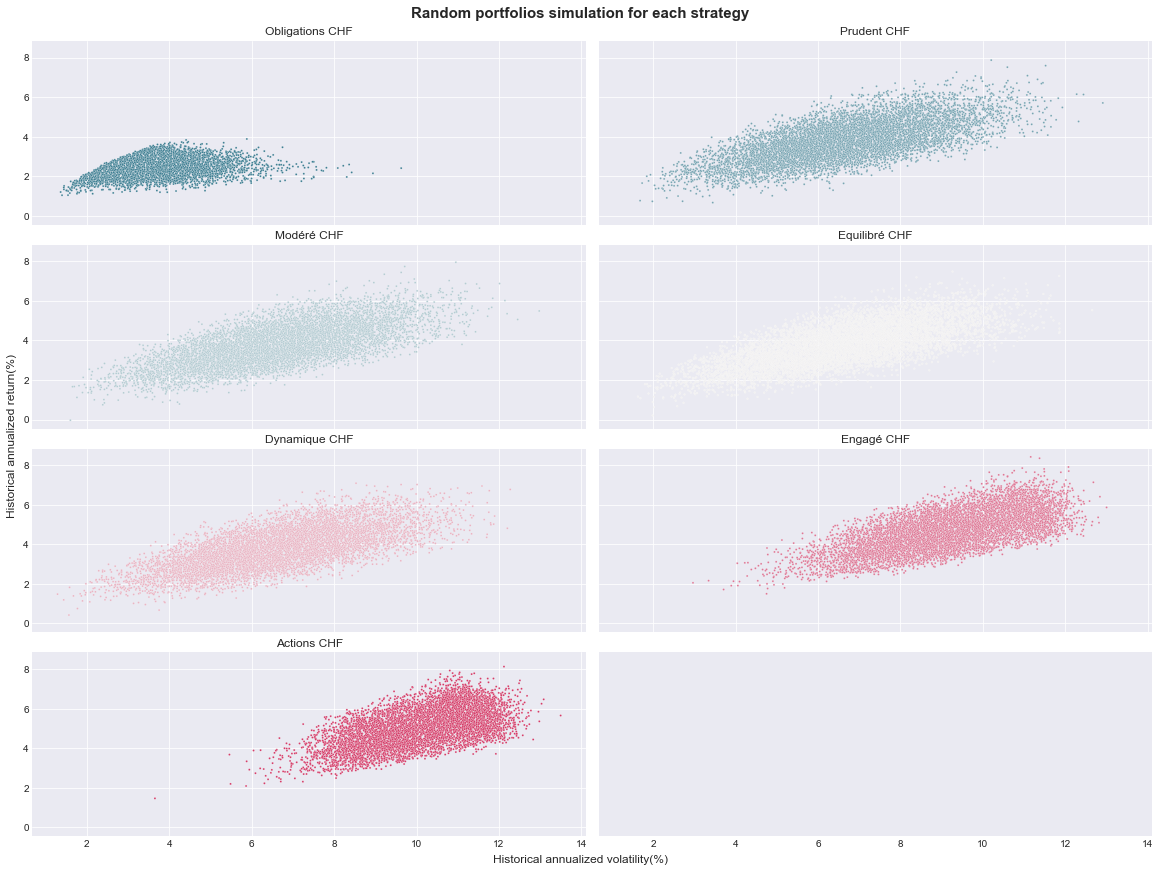

In [119]:
# Random Portfolios
num_portfolios = 10000
# num_assets_min = 5

weight_list = []

df = pd.DataFrame(columns=['returns', 'volatility', 'sharpe_ratio', 'strategie'])

fig, axs = plt.subplots(4,2, figsize=(16,12), sharex=True, sharey=True, constrained_layout=True)
axs = axs.ravel()
pal = sns.diverging_palette(220, 0, n=len(all_strategies), l=50)

for i, strat in enumerate(all_strategies):
    
    port_returns = []
    port_volatility = []
    sharpe_ratio = []
    strat_list = []
    
    data = data_excel.copy()
    all_isin_port = get_all_isin(port, strat=strat, curr=curr, histo_date=date)
    list_isin = list(all_isin_port['No ISIN'])
    data = data[list_isin]
    num_assets_data = data.shape[1]
    
    daily_returns = data.pct_change()
    annual_returns = ((1 + daily_returns.mean())**252 - 1).values
    daily_cov = daily_returns.cov()
    annual_cov = daily_cov.values * 252
    
    for single_port in range(num_portfolios):
        
        weights = np.random.random(num_assets_data)
        weights = np.multiply(weights, np.random.binomial(1, p, size=num_assets_data))
        if np.sum(weights) == 0:
            continue
        weights /= np.sum(weights)
        while np.count_nonzero(weights > 0.02) < num_assets_min_port:
            weights = np.random.random(num_assets_data)
            weights = np.multiply(weights, np.random.binomial(1, p, size=num_assets_data))
            if np.sum(weights) == 0:
                continue
            weights /= np.sum(weights)
        
        returns = weights @ annual_returns
        volatility = np.sqrt(weights.T @ annual_cov @ weights)
        if volatility == 0:
            continue
        sharpe = returns / volatility

        sharpe_ratio.append(sharpe)
        port_returns.append(returns)
        port_volatility.append(volatility)
        weight_list.append(weights)
        strat_list.append(strat)
    
    
    df_temp = pd.DataFrame(data={'returns': port_returns,
                    'volatility': port_volatility,
                    'sharpe_ratio': sharpe_ratio,
                   'strategie': strat_list})
    df_temp.returns *= 100
    df_temp.volatility *= 100

    df_temp = df_temp.loc[round_nearest(df_temp[['returns', 'volatility']],0.05).drop_duplicates(subset=('returns', 'volatility')).index]
    
    df = df.append(df_temp)
    
    axs[i].set_title(strat)
    axs[i] = sns.scatterplot(ax=axs[i], data=df_temp, x='volatility', y='returns', hue='strategie', palette=list((pal[i],)), s=4, legend=False)
    axs[i].grid()
    axs[i].set(xlabel=None)
    axs[i].set(ylabel=None)


df = df.reset_index(drop=True) 
df = df.loc[round_nearest(df[['returns', 'volatility']],0.02).drop_duplicates(subset=('returns', 'volatility')).index]

fig.delaxes(axs[6])
fig.suptitle('Random portfolios simulation for each strategy', fontsize=15, fontweight='bold')
fig.supxlabel('Historical annualized volatility(%)', fontsize=12)
fig.supylabel('Historical annualized return(%)', fontsize=12)
# plt.savefig('pp_output/time_comparison_' + curr + '.png')
plt.show()

#df = pd.DataFrame(data={'returns': port_returns,
#                        'volatility': port_volatility,
#                        'sharpe_ratio': sharpe_ratio,
#                       'strategie': strat_list})
#df.returns = df.returns * 100
#df.volatility = df.volatility * 100
#df = df.loc[round_nearest(df[['returns', 'volatility']],0.05).drop_duplicates(subset=('returns', 'volatility')).index]

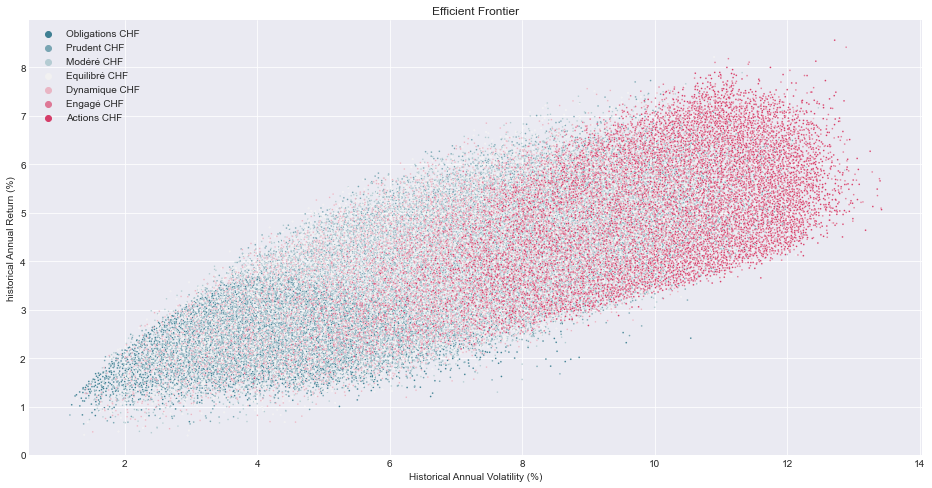

In [64]:
sns.set_style("dark")
pal = sns.diverging_palette(220, 0, n=len(all_strategies), l=50)
fig = plt.figure(figsize=(16,8))
ax1 = sns.scatterplot(data=df, x='volatility', y='returns', hue='strategie', palette=pal, s=3, legend=True)
ax1.legend().set_title(None)
plt.title('Efficient Frontier')
plt.xlabel('Historical Annual Volatility (%)')
plt.ylabel('historical Annual Return (%)')
plt.grid()
plt.show()

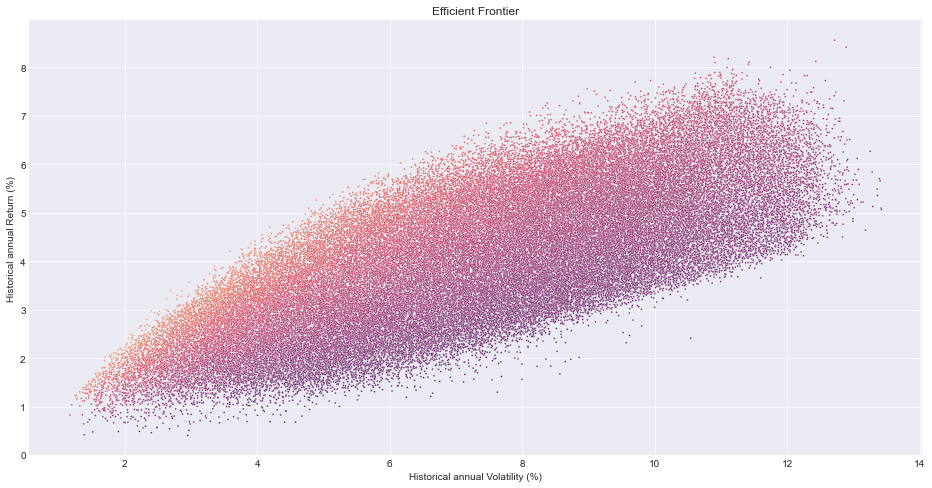

In [65]:
plt.style.use('seaborn-dark')
fig = plt.figure(figsize=(16,8))
ax1 = sns.scatterplot(data=df, x='volatility', y='returns', hue='sharpe_ratio', palette='flare_r', s=3, legend=False)
plt.title('Efficient Frontier')
plt.xlabel('Historical annual Volatility (%)')
plt.ylabel('Historical annual Return (%)')
plt.grid()
plt.show()

# Comparison with strategies

In [66]:
data = data_excel.copy()
all_isin_port = get_all_isin(port, curr=curr)
list_isin = list(all_isin_port['No ISIN'])
data = data[list_isin]
num_assets_data = data.shape[1]

daily_returns = data.pct_change()
annual_returns = ((1 + daily_returns.mean())**252 - 1).values
daily_cov = daily_returns.cov()
annual_cov = daily_cov.values * 252

In [67]:
df_port = pd.DataFrame(columns=['returns', 'volatility', 'sharpe_ratio', 'strategie'])
date_port = date
for strat in all_strategies:
    portfolio = get_weight(port, strat, date_port).reset_index(drop=True)
    portfolio = pd.merge(portfolio, all_isin_port, how='outer', on='No ISIN').fillna(0).drop_duplicates()
    portfolio = portfolio.set_index('No ISIN').reindex(list(all_isin_port['No ISIN']))
    weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
    port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, annual_returns, annual_cov)
    df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol,
                            'sharpe_ratio': port_sharpe, 'strategie': strat}, index=[0])
    df_port = df_port.append(df_temp)
df_port.returns = df_port.returns * 100
df_port.volatility = df_port.volatility * 100

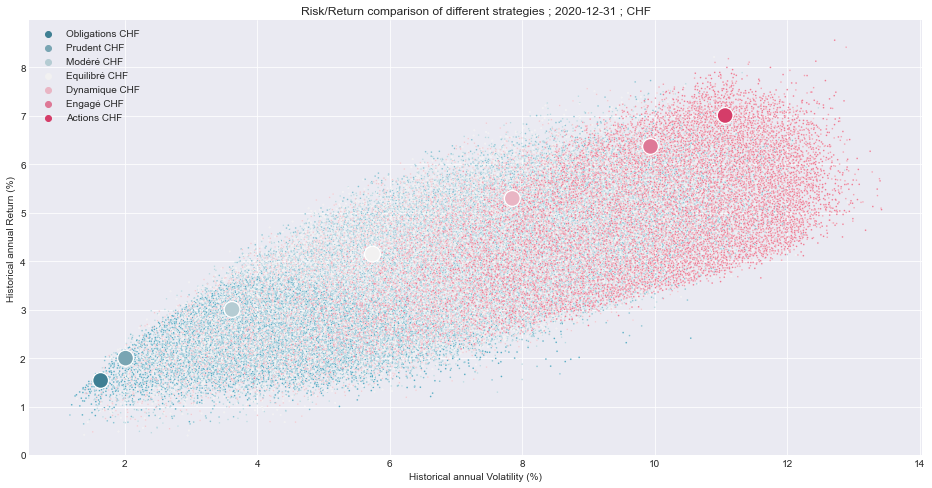

In [68]:
plt.style.use('seaborn-dark')
fig = plt.figure(figsize=(16,8))
pal1 = sns.diverging_palette(220, 0, n=len(df_port), l=65)
pal2 = sns.diverging_palette(220, 0, n=len(df_port))

ax1 = sns.scatterplot(data=df, x='volatility', y='returns', hue='strategie', palette=pal1, s=3, legend=False)
ax2 = sns.scatterplot(data=df_port, x='volatility', y='returns', hue='strategie', palette=pal2, s=250)
# ax3 = sns.lineplot(x=np.array(Sigmap)*100, y=np.array(Mup)*100, sort=False, lw=1, palette="flare")
ax2.legend().set_title(None)
plt.title('Risk/Return comparison of different strategies ; ' + date + ' ; ' + curr)
plt.xlabel('Historical annual Volatility (%)')
plt.ylabel('Historical annual Return (%)')
plt.grid()
plt.savefig('pp_output/Comparison_' + curr + '_' + date + '.png')
plt.show()

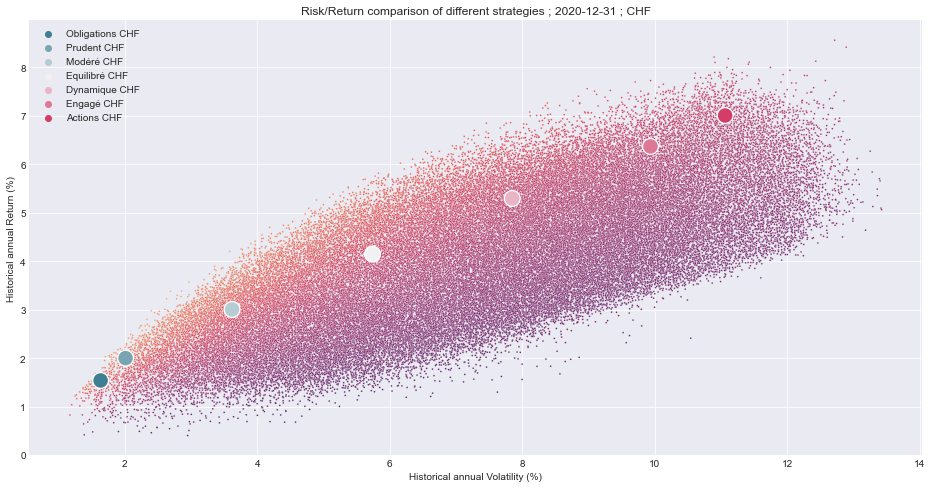

In [69]:
plt.style.use('seaborn-dark')
fig = plt.figure(figsize=(16,8))
ax1 = sns.scatterplot(data=df, x='volatility', y='returns', hue='sharpe_ratio', palette=sns.color_palette("flare_r", as_cmap=True), s=3, legend=False)
ax2 = sns.scatterplot(data=df_port, x='volatility', y='returns', hue='strategie', palette=sns.diverging_palette(220, 0, n=len(df_port)), s=250)
# ax3 = sns.lineplot(x=np.array(Sigmap)*100, y=np.array(Mup)*100, sort=False, lw=1, palette="flare")
ax2.legend().set_title(None)
plt.title('Risk/Return comparison of different strategies ; ' + date + ' ; ' + curr)
plt.xlabel('Historical annual Volatility (%)')
plt.ylabel('Historical annual Return (%)')
plt.grid()
plt.savefig('pp_output/Comparison_' + curr + '_' + date + '.png')
plt.show()

,Obligations CHF,Prudent CHF,Modéré CHF,Equilibré CHF,Dynamique CHF,Engagé CHF,Actions CHF
Top %,30.43,22.97,31.08,34.74,29.22,24.4,19.71
Return delta with best candidate (%),0.49,0.49,1.2,1.67,1.56,1.36,1.17


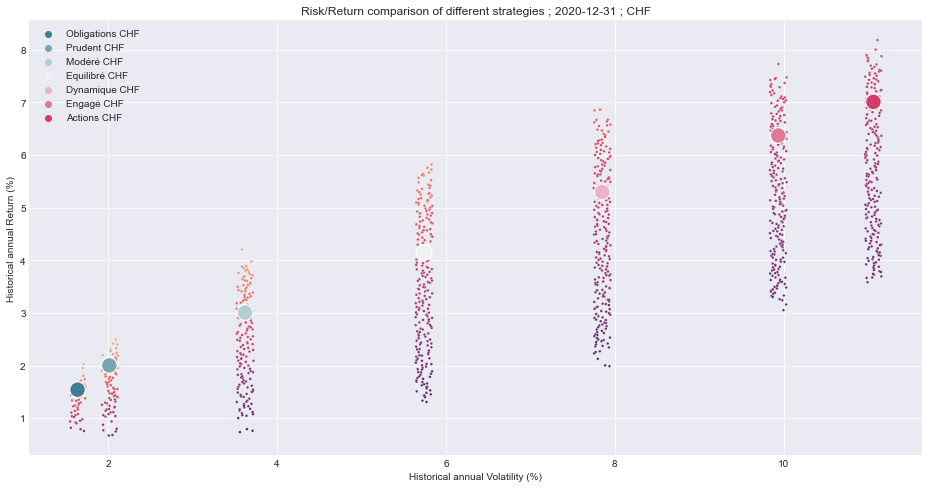

In [70]:
palette = sns.diverging_palette(220, 0, n=len(df_port))
df_strat_concat = pd.DataFrame()
df_port_strat = pd.DataFrame()
df_top_percent = pd.DataFrame(columns=all_strategies)
for pal, strat in zip(palette, all_strategies):
    delta = 0.1
    vol_min = df_port[df_port.strategie == strat].volatility.values[0] - delta
    vol_max = df_port[df_port.strategie == strat].volatility.values[0] + delta
    df_strat = df[(df.volatility > vol_min) & (df.volatility < vol_max)]
    df_strat = df_strat.loc[round_nearest(df_strat['returns'],0.02).drop_duplicates().index]
    df_strat_concat = df_strat_concat.append(df_strat)
    df_port_strat = df_port[df_port.strategie==strat]
    df_strat_all = df_strat.returns.append(df_port_strat.returns).sort_values().reset_index(drop=True)
    strat_top = df_strat_all.index[df_strat_all == df_port_strat.returns.values[0]].to_list()[0]
    strat_top_percent = round(100 * (1 - strat_top / len(df_strat)),2)
    strat_top_dist = round(df_strat.max().values[0] - df_port_strat.returns.values[0],2)
    df_top_percent.at['Top %', strat] = strat_top_percent
    df_top_percent.at['Return delta with best candidate (%)', strat] = strat_top_dist


# df_port['top % between all candidates'] = list(df_top_percent.iloc[0])
#?display(df_port.pivot(columns='strategie', values=['returns', 'volatility', 'sharpe_ratio']))
display(df_top_percent)

fig = plt.figure(figsize=(16,8))
ax1 = sns.scatterplot(data=df_strat_concat, x='volatility', y='returns', hue='sharpe_ratio', palette=sns.color_palette("flare_r", as_cmap=True), s=7, legend=False)
ax2 = sns.scatterplot(data=df_port, x='volatility', y='returns', hue='strategie', palette=palette, s=250)
ax2.legend().set_title(None)
plt.title('Risk/Return comparison of different strategies ; ' + date + ' ; ' + curr)
plt.xlabel('Historical annual Volatility (%)')
plt.ylabel('Historical annual Return (%)')
plt.grid()
plt.show()

# Optimal portfolio frontier

In [71]:
data = data_excel.copy()
all_isin_port = get_all_isin(port, curr=curr)
list_isin = list(all_isin_port['No ISIN'])
data = data[list_isin]
num_assets_data = data.shape[1]

daily_returns = data.pct_change()
annual_returns = ((1 + daily_returns.mean())**252 - 1).values
daily_cov = daily_returns.cov()
annual_cov = daily_cov.values * 252

In [72]:
Sigmap = []
Mup_min = df.returns.iloc[df.volatility.argmin()] / 100
Mup_max = df.returns.max() / 100
Mup = np.linspace(0, Mup_max, 100)
for target in tqdm(Mup):
    Sigmap.append(efficientOpt(annual_returns, annual_cov, target)['fun'])

100%|██████████| 100/100 [00:03<00:00, 31.49it/s]


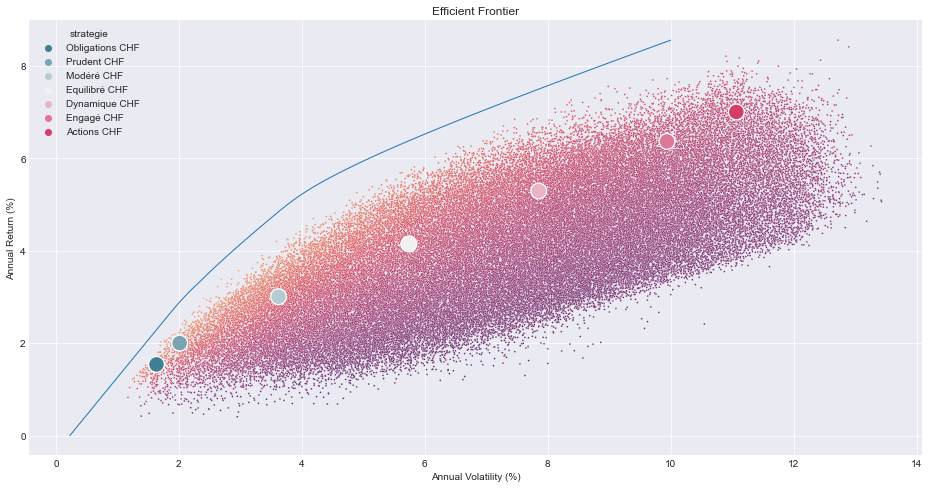

In [73]:
plt.style.use('seaborn-dark')
fig = plt.figure(figsize=(16,8))
ax1 = sns.scatterplot(data=df, x='volatility', y='returns', hue='sharpe_ratio', palette=sns.color_palette("flare_r", as_cmap=True), s=3, legend=False)
ax2 = sns.lineplot(x=np.array(Sigmap)*100, y=np.array(Mup)*100, sort=False, lw=1, palette="flare")
ax3 = sns.scatterplot(data=df_port, x='volatility', y='returns', hue='strategie', palette=sns.diverging_palette(220, 0, n=len(df_port)), s=250)
plt.title('Efficient Frontier')
plt.xlabel('Annual Volatility (%)')
plt.ylabel('Annual Return (%)')
plt.grid()
plt.show()

# DRAFT

In [74]:
# Efficient Frontier
Sigmap = []
Mup_min = df.returns.min() / 100
Mup_max = df.returns.max() / 100
Mup = np.linspace(0, Mup_max, 10)
for target in tqdm(Mup):
    Sigmap.append(efficientOpt(annual_returns, annual_cov, target)['x'])

100%|██████████| 10/10 [00:00<00:00, 31.06it/s]


In [75]:
# df_test = pd.DataFrame(columns=Mup, data=np.array(Sigmap).T)
# (df_test*100).round(2)

In [76]:
np.count_nonzero(np.array(Sigmap)==0, axis=1)

array([ 6,  6,  7,  5,  5,  5, 13,  9,  7, 11])

In [77]:
num_asset_port = []
for strat in all_strategies:
    portfolio = get_weight(taa_port, strat, date_port)
    num_asset_port.append(len(portfolio))
np.array(num_asset_port)

array([0, 0, 0, 0, 0, 0, 0])